# 作業 : (Kaggle)鐵達尼生存預測

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 使用葉編碼並觀察預測效果

# [作業重點]
- 仿造範例, 完成葉編碼的寫作 : 使用隨機森林 (In[3], Out[3], In[4], Out[4])
- 仿造範例, 觀察葉編碼搭配邏輯斯迴歸後的效果 (In[5], Out[5], In[6], Out[6]) 

In [1]:
# 抓取資料
!wget -c https://ai100-fileentity.cupoy.com/ml100/homework/data/1582795766653/titanic_test.csv?t=1582795815962 -O titanic_test.csv
!wget -c https://ai100-fileentity.cupoy.com/ml100/homework/data/1582795766653/titanic_train.csv?t=1582795819472 -O titanic_train.csv

--2020-08-02 09:06:01--  https://ai100-fileentity.cupoy.com/ml100/homework/data/1582795766653/titanic_test.csv?t=1582795815962
Resolving ai100-fileentity.cupoy.com (ai100-fileentity.cupoy.com)... 13.224.29.81, 13.224.29.48, 13.224.29.13, ...
Connecting to ai100-fileentity.cupoy.com (ai100-fileentity.cupoy.com)|13.224.29.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28210 (28K) [application/octet-stream]
Saving to: ‘titanic_test.csv’

titanic_test.csv    100%[===================>]  27.55K  --.-KB/s    in 0.004s  

2020-08-02 09:06:01 (6.53 MB/s) - ‘titanic_test.csv’ saved [28210/28210]

--2020-08-02 09:06:03--  https://ai100-fileentity.cupoy.com/ml100/homework/data/1582795766653/titanic_train.csv?t=1582795819472
Resolving ai100-fileentity.cupoy.com (ai100-fileentity.cupoy.com)... 13.224.29.13, 13.224.29.81, 13.224.29.48, ...
Connecting to ai100-fileentity.cupoy.com (ai100-fileentity.cupoy.com)|13.224.29.13|:443... connected.
HTTP request sent, awaiting res

In [2]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# 因為擬合(fit)與編碼(transform)需要分開, 因此不使用.get_dummy, 而採用 sklearn 的 OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

#data_path = 'data/'
df = pd.read_csv('titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [4]:
train_X = df.values
# 因為訓練邏輯斯迴歸時也要資料, 因此將訓練及切成三部分 train / val / test, 採用 test 驗證而非 k-fold 交叉驗證
# train 用來訓練梯度提升樹, val 用來訓練邏輯斯迴歸, test 驗證效果
train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=0.5)
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.5)

# 作業1
* 請對照範例，完成隨機森林的鐵達尼生存率預測，以及對應的葉編碼+邏輯斯迴歸

In [5]:
# 隨機森林擬合後, 再將葉編碼 (*.apply) 結果做獨熱 / 邏輯斯迴歸
rf = RandomForestClassifier(n_estimators=20, min_samples_split=10, min_samples_leaf=5, 
                            max_features=4, max_depth=3, bootstrap=True)
onehot = OneHotEncoder()
lr = LogisticRegression(solver='lbfgs', max_iter=1000)

rf.fit(train_X, train_Y)
onehot.fit(rf.apply(train_X))
lr.fit(onehot.transform(rf.apply(val_X)), val_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [6]:
# 將隨機森林+葉編碼+邏輯斯迴歸結果輸出
pred_rf_lr = lr.predict_proba(onehot.transform(rf.apply(test_X)))[:, 1]
fpr_rf_lr, tpr_rf_lr, _ = roc_curve(test_Y, pred_rf_lr)
# 將隨機森林結果輸出
pred_rf = rf.predict_proba(test_X)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(test_Y, pred_rf)

# 作業2
* 上述的結果，葉編碼是否有提高預測的正確性呢?
> 以roc_auc而言(下圖), 看起來效果不是很明顯, 範例中的結果甚至反過來  
大家可以嘗試自己多跑幾次, 結果可能都有些差異  
所以葉編碼效果仍要看資料而定, 未必一定比較好, 而是提供多一個方式讓大家選擇

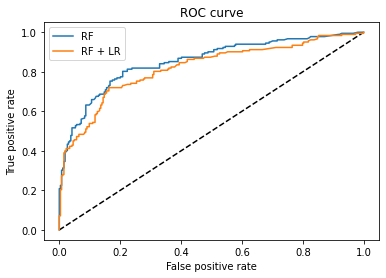

In [7]:
import matplotlib.pyplot as plt
# 將結果繪圖
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lr, tpr_rf_lr, label='RF + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()